# 01 – Data Exploration

In this notebook we will:

1. Load our train / validation / test splits  
2. Confirm data integrity (no missing values, correct columns)  
3. Spot-check random examples per emotion  
4. Examine class distributions per split (Seaborn plots)  
5. (Optional) Inspect text-length distributions  

All data files were generated by `scripts/1_load_data.py`.


In [1]:
# — Imports & Setup
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Seaborn styling
%matplotlib inline
sns.set_theme(style="whitegrid")

# Point to data directory
DATA_DIR = Path.cwd().parent / "data"

c:\Users\Inbal\anaconda3\envs\env_emotion_detection\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load CSV Splits via `datasets`

We’ll use `load_dataset("csv", …)` to pull in our local files as a DatasetDict.

In [2]:
# — Load local CSVs
ds = load_dataset("csv", data_files={
    "train": str(DATA_DIR / "train.csv"),
    "validation": str(DATA_DIR / "validation.csv"),
    "test": str(DATA_DIR / "test.csv")
})

# Inspect dataset sizes and columns
print(ds)

Generating train split: 16000 examples [00:00, 479990.16 examples/s]
Generating validation split: 2000 examples [00:00, 266753.84 examples/s]
Generating test split: 2000 examples [00:00, 269955.85 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'emotion'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'emotion'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'emotion'],
        num_rows: 2000
    })
})


Now convert each split into a pandas DataFrame for detailed inspection.

In [3]:
# — To pandas
df_train = ds["train"].to_pandas()
df_val   = ds["validation"].to_pandas()
df_test  = ds["test"].to_pandas()

print("Train:", df_train.shape, "| Validation:", df_val.shape, "| Test:", df_test.shape)

Train: (16000, 2) | Validation: (2000, 2) | Test: (2000, 2)


## 2. Data Integrity Checks

Ensure each DataFrame has:
- Exactly two columns: `text` and `label`  
- No missing values  
- Correct data types

In [4]:
# Column names and types
display(df_train.dtypes)

# Missing values
for split, df in [("train", df_train), ("validation", df_val), ("test", df_test)]:
    print(f"{split}: {df.isna().sum().sum()} missing values")

text       object
emotion    object
dtype: object

train: 0 missing values
validation: 0 missing values
test: 0 missing values


> **Observation:** 
No missing values; columns `text` (string) and `emotion` (string) look correct.

## 3. Spot-Check Random Examples

View random text per emotion from the training set to manually verify quality.

In [5]:
n_samples = 3  # Number of examples to sample per emotion

for emotion in sorted(df_train.emotion.unique()):
    print(f"--- {emotion.upper()} ---")
    samples = df_train[df_train.emotion == emotion].sample(n_samples, random_state=42)
    for idx, row in samples.iterrows():
        print(f"# {row.text}")
    print("\n")


--- ANGER ---
# i ve been feeling a bit cranky with the kids this week cranky baby whiny year old demanding preschooler so i wanted to stop and remember how blessed i really am
# i feel frustrated sometimes with my mac lipsticks when i have to read names or open each of them to select shade
# i feeling stressed


--- FEAR ---
# i can feel the frantic beat of his heart but cookie s voice is surprisingly clear
# i feel a little suspicious
# i can t help but feeling weird when opening every closet in an apartment that somebody s still living in so i didn t


--- JOY ---
# i feel im rather innocent in that respect
# im feeling quite adventurous and tried out those drinks that i just normally read through the pages of pocketbooks
# im feeling much more positive about the impending move


--- LOVE ---
# i mean fuck i feel like i was way more considerate with customers and concerned about appearance and sanitiation snoozel pm but fine
# i remember a couple of years ago i was feeling romantic 

## 3a.
> **Observation:** <br>
1. **All lowercase**  
   Every example is in lowercase, even proper names and sentence starts.

2. **Missing punctuation & apostrophes**  
   - No commas, periods, question marks, or apostrophes in any sample.  
   - Contractions like “I’m” appear as “im”, and possessives like “someone’s” as “somebody s”.

3. **Typos and irregular spacing**  
   - Words run together or are split by extra spaces (e.g. “sanitiation snoozel pm”).  
   - A few clear misspellings (“sanitiation”, “impend­ing”).

4. **Grammatical fragments**  
   - Some fragments lack verbs or have truncated clauses (“i feeling stressed”).  
   - One “sadness” entry is completely empty (noted as `…`).

5. **Informal or profane language**  
   - Expletives (“fuck”) appear in the “love” samples—this may be noise or a signal depending on your chosen approach.
---



## 3b. Implications & Next Steps

- **Normalization & Cleaning**  
  - Expand contractions (`im` → `I’m`, `dont` → `don’t`).  
  - Correct common typos and remove extra spaces.  
  - Optionally mask or handle profanity.

- **Drop Invalid Rows**  
  - Remove any rows where `text` is empty or extremely short (e.g. <3 characters).

- **Tokenization Strategy**  
  - Rely on a subword tokenizer (e.g. BERT’s WordPiece) that handles run-on text.  
  - Consider re-inserting a sentence terminator (period) at the end of each text.

- **Re-evaluate Distributions**  
  - After cleaning, rerun class-balance and length-distribution plots to confirm no unintended skew.

---

## 3c. Action Plan

1. **Add a “Cleaning” section** below that applies a `clean_text()` function to each split.  
2. **Implement `clean_text()`**


🔧 Implications & Next Steps
Normalization & Cleaning

* Restore punctuation/apostrophes by running a contraction-expansion step (e.g. im → I’m, dont → don’t).

* Spell-check or autocorrect common misspellings with something like TextBlob or SymSpell.

* Trim extra spaces and remove any non-text tokens (timestamps like “pm”).

* Handle Empty or Invalid Rows

* Drop rows where text is empty or shorter than a minimal length (e.g. <3 characters).

* Log how many you drop and which emotion they belonged to.

* Profanity & Noise

* Optionally replace or mask profanity if you want to reduce noise—though a model might learn that profanity correlates with certain emotions.

* Tokenization Strategy

* Given the lack of punctuation, rely on subword tokenizers (e.g. BERT’s WordPiece) that can handle run-on text.

* Consider adding a preprocessing step to re-insert a single period at line-end for tokenizers that expect full sentences.

* Update Exploration Notebook

* After cleaning, rerun your class-distribution plots and text-length histograms on the cleaned DataFrames to confirm no class drift or length outliers.

# TODO: 
Make 3a-3c the same type as observation (>) <br>
Decide which stays here as a note or anywhere alls and which is just a conclusion that will be dealt with and than the comment will be deleted

## 4. Class Distribution per Split

Visualize how many examples of each emotion appear in each split.

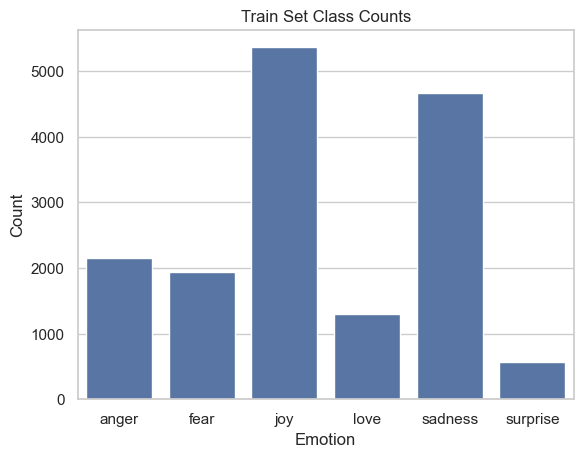

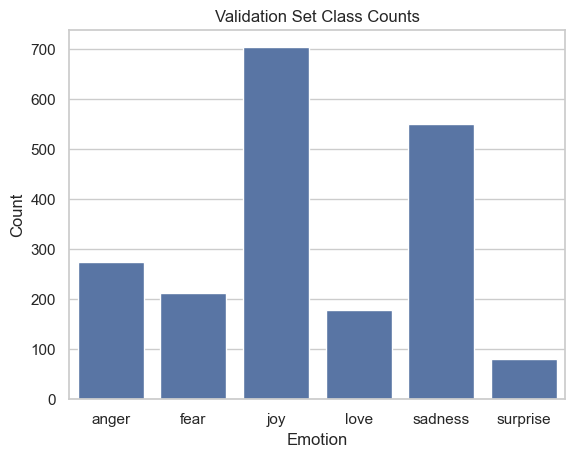

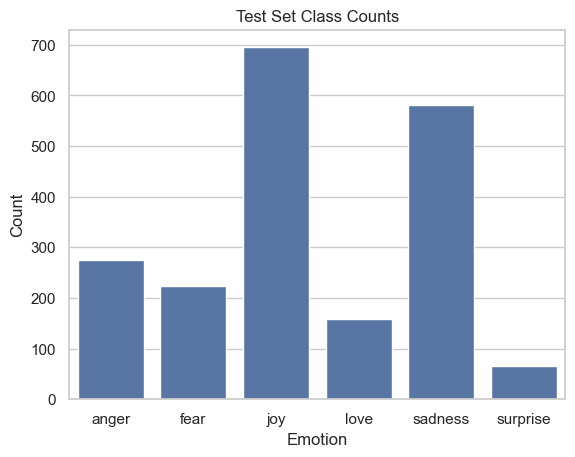

In [6]:
def plot_counts(df, title):
    sns.countplot(x="emotion", data=df, order=sorted(df.emotion.unique()))
    plt.title(title)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.show()

plot_counts(df_train, "Train Set Class Counts")
plot_counts(df_val,   "Validation Set Class Counts")
plot_counts(df_test,  "Test Set Class Counts")

## TODO:
* Optionaly put them all together in the same graph, colored by type of df (with legend)
* The bars alligned horizontaly

> **Observation:** The splits are equaly split for all df's, however the classes are imbalanced and should be dealt with.

## 5. Text-Length Distribution

Check character-length distributions to guide our max-token-length choice for transformers.


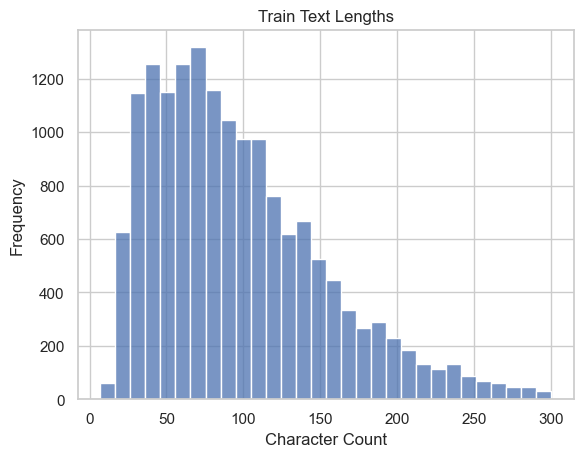

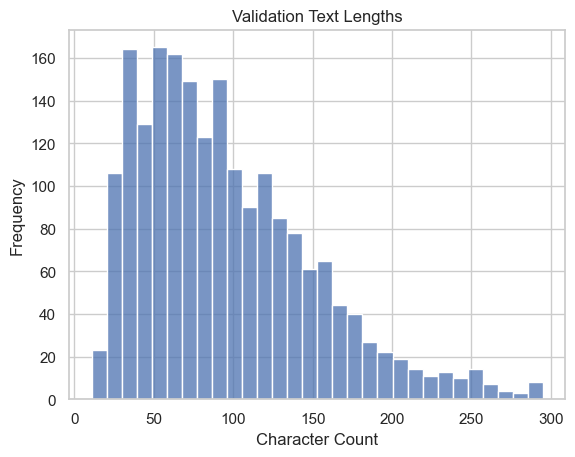

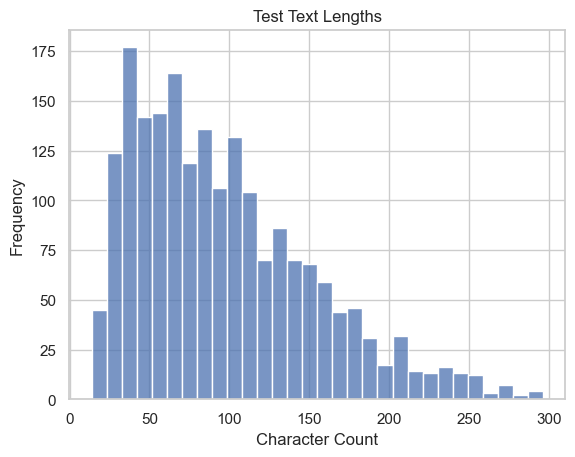

In [7]:
for split, df in [("Train", df_train), ("Validation", df_val), ("Test", df_test)]:
    sns.histplot(df.text.str.len(), bins=30)
    plt.title(f"{split} Text Lengths")
    plt.xlabel("Character Count")
    plt.ylabel("Frequency")
    plt.show()

## TODO: 
* Add mean
* Add median
* Add quartiles
* Add observation

> **Insight:** Most texts range from ~10–150 characters, so a 128-token limit will cover nearly all inputs.

---

### Next Steps

Proceed to:
- **Clean text:**  Add a noramlization and cleaning of the data so it will be usable, before training (could be in a basic level)
- **Plots:** Add plots marks from TODOs and add observations
- **Class Imbalance:** Refer to it and treat it=
- **Section 3:** `02_tfidf_baseline.ipynb` (TF–IDF + shallow classifiers)  
- **Section 4:** `03_transformer_finetune.ipynb` (transformer fine-tuning)
- **TODOs:** Refer to all the TODOs that I haven't completed yet
- **Change Observations' View:** Fix it so that the view will be the same as before in former observations (>) and not like 3a. 3b. 3c. for example